## Resources
- https://xgboost.readthedocs.io/en/stable/get_started.html
- https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

In [1]:
%reload_kedro

2023-10-09 13:52:10,843 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: C:\Users\Dushku\PycharmProjects\monash-datahack-2023
2023-10-09 13:52:11,045 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-10-09 13:52:11,079 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-telemetry-0.2.5
2023-10-09 13:52:11,163 - kedro.extras.extensions.ipython - INFO - ** Kedro project Monash datahack 2023
2023-10-09 13:52:11,165 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\kedro\framework\context\context.py:344: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\Users\\Dushku\\PycharmProjects\\monash-datahack-2023\\conf\\base', 'C:\\Users\\Dushku\\PycharmProjects\\monash-datahack-2023\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [2]:
df = catalog.load('encoded_data_without_australia')

2023-10-09 13:52:11,172 - kedro.io.data_catalog - INFO - Loading data from `encoded_data_without_australia` (CSVDataSet)...


In [3]:
df.head()

,y,Jurisdiction_encoded,Sub-stream,Category_encoded,Type_encoded,Management_encoded,Fate_encoded,ds_encoded
0,4594,0,3,1,6,3,0,14
1,0,0,3,1,6,4,3,14
2,4594,0,9,1,6,3,0,14
3,0,0,9,1,6,4,3,14
4,0,0,2,2,5,4,3,14


In [4]:
df.columns

Index(['y', 'Jurisdiction_encoded', 'Sub-stream', 'Category_encoded',
       'Type_encoded', 'Management_encoded', 'Fate_encoded', 'ds_encoded'],
      dtype='object')

XGBoost requires special handling for categorical data
https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

In [5]:
cat_columns = ['Jurisdiction_encoded', 'Sub-stream', 'Category_encoded', 'Type_encoded', 'Management_encoded', 'Fate_encoded']
for column in cat_columns:
    df[column].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53983 entries, 0 to 53982
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   y                     53983 non-null  int64
 1   Jurisdiction_encoded  53983 non-null  int64
 2   Sub-stream            53983 non-null  int64
 3   Category_encoded      53983 non-null  int64
 4   Type_encoded          53983 non-null  int64
 5   Management_encoded    53983 non-null  int64
 6   Fate_encoded          53983 non-null  int64
 7   ds_encoded            53983 non-null  int64
dtypes: int64(8)
memory usage: 3.3 MB


In [7]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [8]:
X = df.loc[:, df.columns != 'y']
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", 
                             enable_categorical=True, 
                             # Improves data with outliers
                             eval_metric= 'mae', 
                             n_estimators = 1000,
                             learning_rate = 0.3
                            )

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)

print(mse)

368230.703527399


In [9]:
r2_score = r2_score(y_test, y_pred)

print(r2_score)

0.9064968516675251


In [10]:
xgb_model.get_booster().get_score(importance_type="weight")

{'Jurisdiction_encoded': 15265.0,
 'Sub-stream': 7959.0,
 'Category_encoded': 3853.0,
 'Type_encoded': 13423.0,
 'Management_encoded': 6026.0,
 'Fate_encoded': 3010.0,
 'ds_encoded': 10268.0}

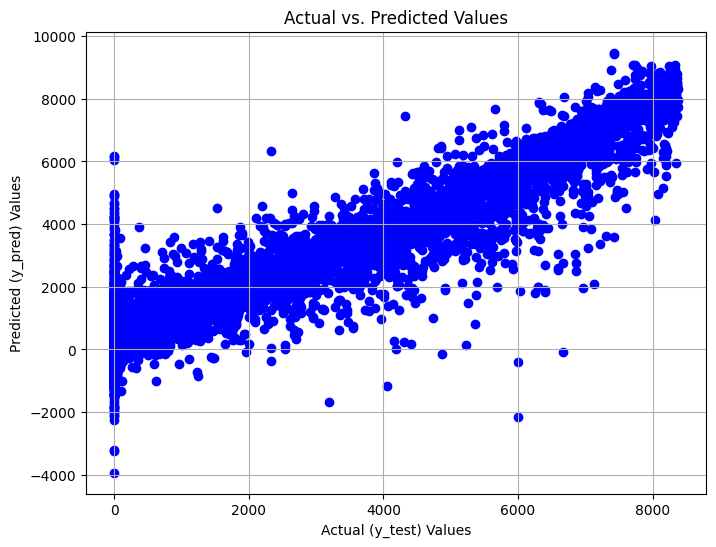

In [11]:
import matplotlib.pyplot as plt
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', marker='o')
plt.xlabel('Actual (y_test) Values')
plt.ylabel('Predicted (y_pred) Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV

def gridsearch():
    xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
    parameters = {}
    clf = GridSearchCV(xgb_model, parameters)
    clf.fit(X_train, y_train) 
    clf.predict(X_test)
    print(xgb_model.score(X_test, y_test))
    
gridsearch()

C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [13:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [13:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [13:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src

NotFittedError: need to call fit or load_model beforehand